In [114]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Get the data and the classifier

In [115]:
from tensorflow.keras.utils import to_categorical

from utils.dataset import get_train_test_data

# get the train and test data in rgb format
(train_data, train_labels), (test_data, test_labels) = get_train_test_data(rgb=True, verbose=True)
# Turn the labels into one-bit-hot-encoding
train_labels_cat, test_labels_cat = to_categorical(train_labels), to_categorical(test_labels)

Train samples: 60000
Test samples: 10000
Data shape: (28, 28, 3)


### Visualize the distribution of the data

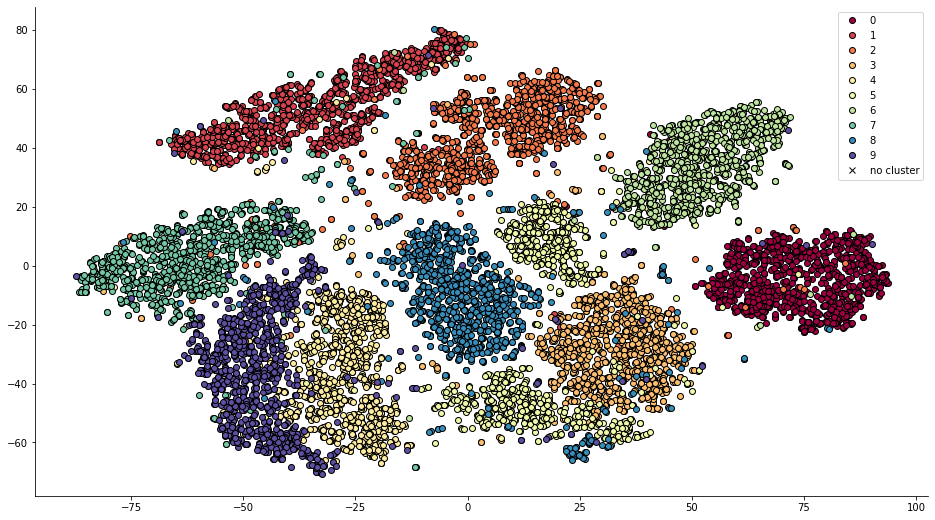

In [123]:
from utils.cluster.visualize import visualize_clusters
import tensorflow as tf

visualize_clusters(tf.image.rgb_to_grayscale(test_data).numpy(), test_labels)

In [116]:
from DigitClassifier import DigitClassifier

# Create an instance of the classifier and train it
classifier = DigitClassifier()
classifier.fit(train_data, train_labels, epochs=1)
loss, acc = classifier.evaluate(test_data, test_labels)
print(f'Accuracy on test: {acc}')

313/313 [==============================] - 1s 2ms/step - loss: 0.0504 - sparse_categorical_accuracy: 0.9836
Accuracy on test: 0.9836000204086304


# Generate the explanations for the predictions

### Filter for the misclassified data of the desired label

In [117]:
import numpy as np

# compute the predictions
predictions = classifier.predict(test_data).argmax(axis=-1)
# get the mask for the misclassified data
misclassified_mask = test_labels != predictions
# get the mask for the label
most_misclassified = sorted(list(zip(*np.unique(test_labels[misclassified_mask], return_counts=True))), key=lambda item: -item[1])[0][0]
label_mask = test_labels == most_misclassified
# get the filtered data and labels
complete_mask = misclassified_mask & label_mask
filtered_data = test_data[complete_mask]
filtered_real_labels = test_labels_cat[complete_mask]
filtered_wrong_labels = to_categorical(predictions[complete_mask], num_classes=10)
print(f'Selected {filtered_data.shape[0]}/{test_data.shape[0]} instances for misclassified {most_misclassified}')

Selected 36/10000 instances for misclassified 7


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Positive contributions'}>)

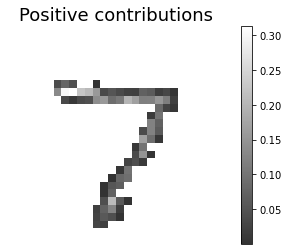

In [131]:
from utils.plotter import ContributionsMode, show_contributions
from xplique.attributions import IntegratedGradients
import numpy as np
import tensorflow as tf

# generate the explanations for the images
explainer = IntegratedGradients(classifier, steps=50)
contributions = explainer.explain(test_data, test_labels_cat).numpy()
# convert the contributions to grayscale
contributions_gs = np.squeeze(tf.image.rgb_to_grayscale(contributions).numpy())
show_contributions(mode=ContributionsMode.POSITIVE, contributions=contributions_gs[0], cmap='gray')

### Visualize the distribution of the heatmaps

In [142]:
from utils.dimensionality_reduction.dimensionality_reduction import tsne

# reduce teh dimensionality of the contributions
contributions_2d = tsne(contributions_gs.reshape(contributions_gs.shape[0], -1))
contributions_2d.shape

(10000, 2)

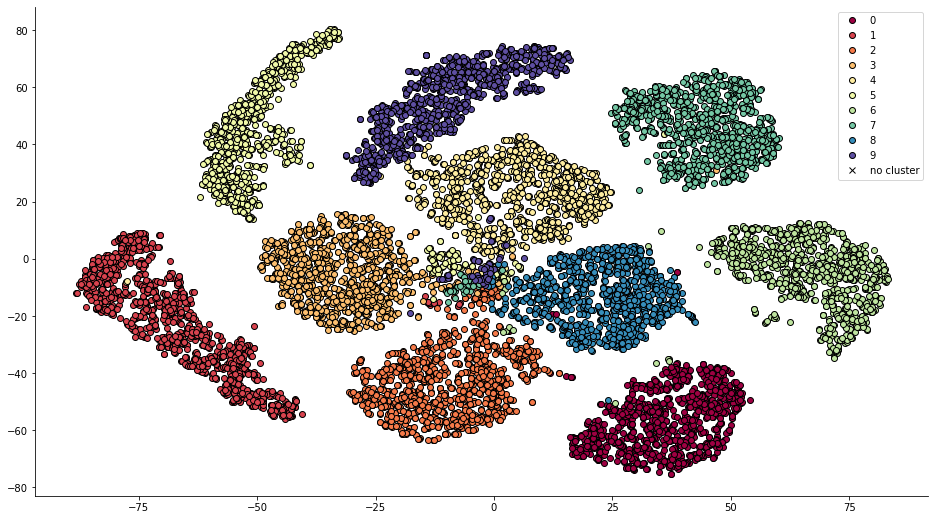

In [153]:
clusters_fig, clusters_ax = visualize_clusters(contributions_2d, test_labels)

# Cluster the heatmaps

### Compute the distance matrix

In [144]:
from utils.cluster.preprocessing import distance_matrix
from utils.image_similarity.intensity_based import euclidean_distance

# filter for the selected contributions
filtered_contributions = contributions_gs[complete_mask]
# compute the distance matrix for the contributions
dist_matrix = distance_matrix(filtered_contributions, dist_func=euclidean_distance)
dist_matrix[:4, :4]

array([[0.        , 0.88237649, 0.93086785, 0.87193966],
       [0.88237649, 0.        , 1.03682649, 0.96028191],
       [0.93086785, 1.03682649, 0.        , 0.81996906],
       [0.87193966, 0.96028191, 0.81996906, 0.        ]])

### Find the optimal parameters for DBSCAN

The point of maximum curvature is 0.7324291752552399


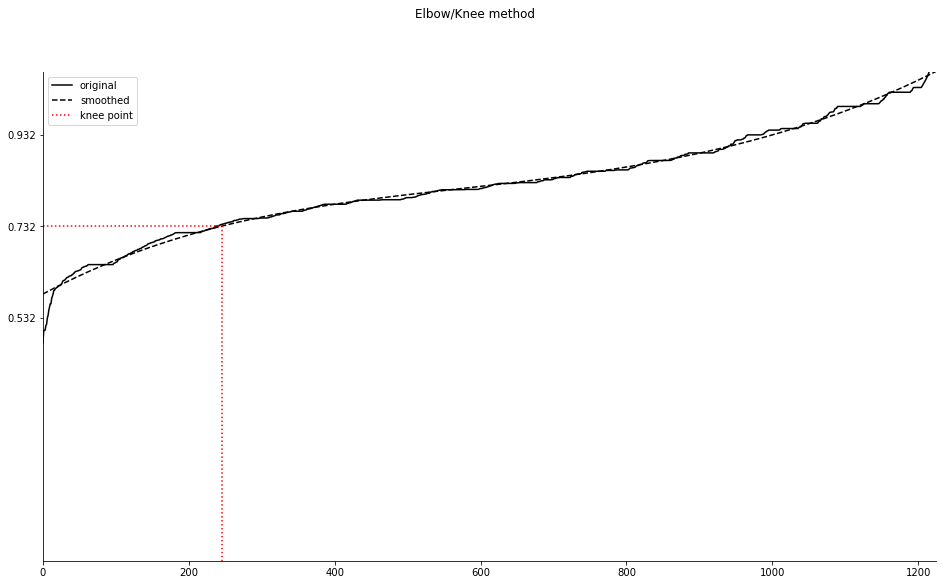

In [145]:
from utils.image_similarity.stats import get_elbow_point

elbow_point, fig, _ = get_elbow_point(dist_matrix, smoothing_factor=.1, plot=True)
print(f'The point of maximum curvature is {elbow_point}')
fig.suptitle('Elbow/Knee method')
fig.savefig('../out/elbow_point.png', dpi=300, transparent=True)


Silhouette score = 0.4606069696094433
    min_samples = 9
    eps = 0.7324291752552399 
        


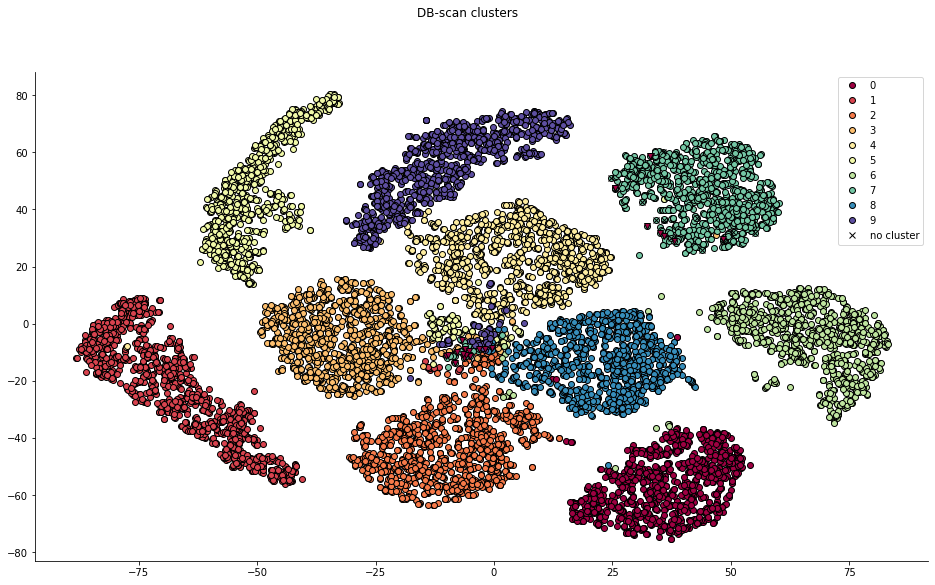

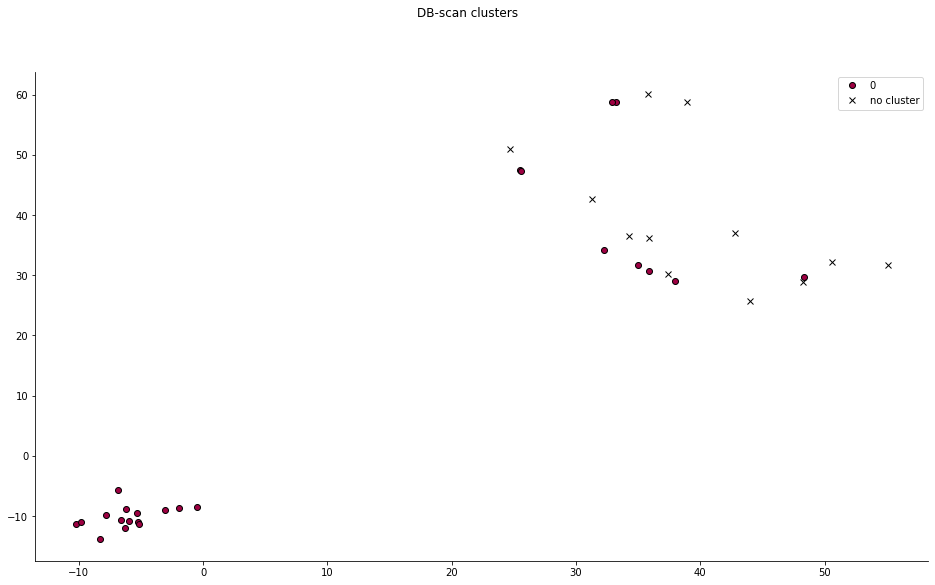

In [156]:
from utils.cluster.visualize import visualize_clusters
from utils.cluster.techniques.density_based_cluster import density_based_cluster_tuned

# generate the clusters based on the distance matrix
clusters = density_based_cluster_tuned(
    dist_matrix,
    min_samples_list=range(1, 11), eps=elbow_point,
    verbose=True
)
fig, _ = visualize_clusters(heatmaps=contributions_2d[complete_mask], clusters=clusters)
fig.suptitle('DB-scan clusters')
fig.savefig('../out/bdscan.png', dpi=300, transparent=True)
clusters_fig